# UCI HAR - classification
- https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones

#### 데이터 종류
- 561개 특성으로 전처리된 메인 데이터셋(X_train, X_test)
- Inertial Signals 데이터셋: 원시 센서 값(raw signal)

#### Inertial Signals 데이터 구조
- 각 파일은 행 = 샘플(segment), 열 = 시계열 프레임을 의미
- 각 샘플은 2.56초 길이 (샘플링 주파수 50Hz, 128 타임스텝 → 128 / 50 = 2.56초)
- 이미 샘플링이 되어 있으므로(7352개의 샘플) split_sequence() 사용하지 않아도 됨
- 한 행이 (128,) 길이의 시계열 벡터
- 세 축(X, Y, Z)와 센서 종류(acc, gyro)로 분리되어 있음

#### 센서 및 값의 의미
- Total acceleration (total_acc): 스마트폰 가속도계로 측정한 총 가속도 (중력 + 신체 움직임 포함)
- Body acceleration (body_acc): 총 가속도에서 중력 성분을 제거한 값 (실제 동작 가속도)
- Gyroscope (body_gyro): 각속도(회전 속도), 단위는 rad/sec, 스마트폰의 자이로스코프 센서 값

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input, LSTM, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]

In [4]:
TRAIN = "train/"
TEST = "test/"

DATASET_PATH = "/content/drive/MyDrive/AI_data/UCI HAR Dataset/"

# Load "X"
def load_X(X_signals_paths):
    X_signals = []

    for signal_type_path in X_signals_paths:
        series_list = []  # 한 센서축 데이터 전체 저장

        with open(signal_type_path, 'r') as file:
            for row in file:
                row_clean = row.replace('  ', ' ') # 공백 2개를 1개로
                row_clean = row_clean.strip() # 양쪽 공백 제거
                serie = row_clean.split(' ') # 공백 기준 split
                serie_array = np.array(serie, dtype=np.float32) # float32 numpy 배열로 변환
                series_list.append(serie_array) # 시퀀스 추가

        # 하나의 센서축 데이터 추가 (feature)
        X_signals.append(series_list)

    # shape: (특성 수, 샘플 수, 타임스텝 수)
    X_signals = np.array(X_signals)
    # shape 변환 → (샘플 수, 타임스텝 수, 특성 수)
    return np.transpose(X_signals, (1, 2, 0))


X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt"
    for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt"
    for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("첫 번째 샘플 데이터:\n", X_train[0])


X_train shape: (7352, 128, 9)
X_test shape: (2947, 128, 9)
첫 번째 샘플 데이터:
 [[ 1.808515e-04  1.076681e-02  5.556068e-02 ...  1.012817e+00
  -1.232167e-01  1.029341e-01]
 [ 1.013856e-02  6.579480e-03  5.512483e-02 ...  1.022833e+00
  -1.268756e-01  1.056872e-01]
 [ 9.275574e-03  8.928878e-03  4.840473e-02 ...  1.022028e+00
  -1.240037e-01  1.021025e-01]
 ...
 [-1.147484e-03  1.714439e-04  2.647864e-03 ...  1.018445e+00
  -1.240696e-01  1.003852e-01]
 [-2.222655e-04  1.574181e-03  2.381057e-03 ...  1.019372e+00
  -1.227451e-01  9.987355e-02]
 [ 1.575500e-03  3.070189e-03 -2.269757e-03 ...  1.021171e+00
  -1.213260e-01  9.498741e-02]]


In [5]:
# Load "y"

def load_y(y_path):
    with open(y_path, 'r') as file:
        labels = [int(line.strip()) for line in file]
    # 라벨을 0부터 시작하도록 -1 (원래 라벨이 1부터 시)
    return np.array(labels, dtype=np.int32) - 1


y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print(y_train[:5])

y_train shape: (7352,)
y_test shape: (2947,)
[4 4 4 4 4]


In [6]:
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = 6

model = Sequential([
            Input(shape=input_shape),
            GRU(128, return_sequences=True, dropout=0.2),
            GRU(64, return_sequences=False, dropout=0.2),
            Dense(32, activation='relu'),
            Dropout(0.3),
            Dense(num_classes, activation='softmax')
        ])

model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
        )

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 128, 128)       │        53,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,902 (362.90 KB)

 Trainable params: 92,902 (362.90 KB)

 Non-trainable params: 0 (0.00 B)

None


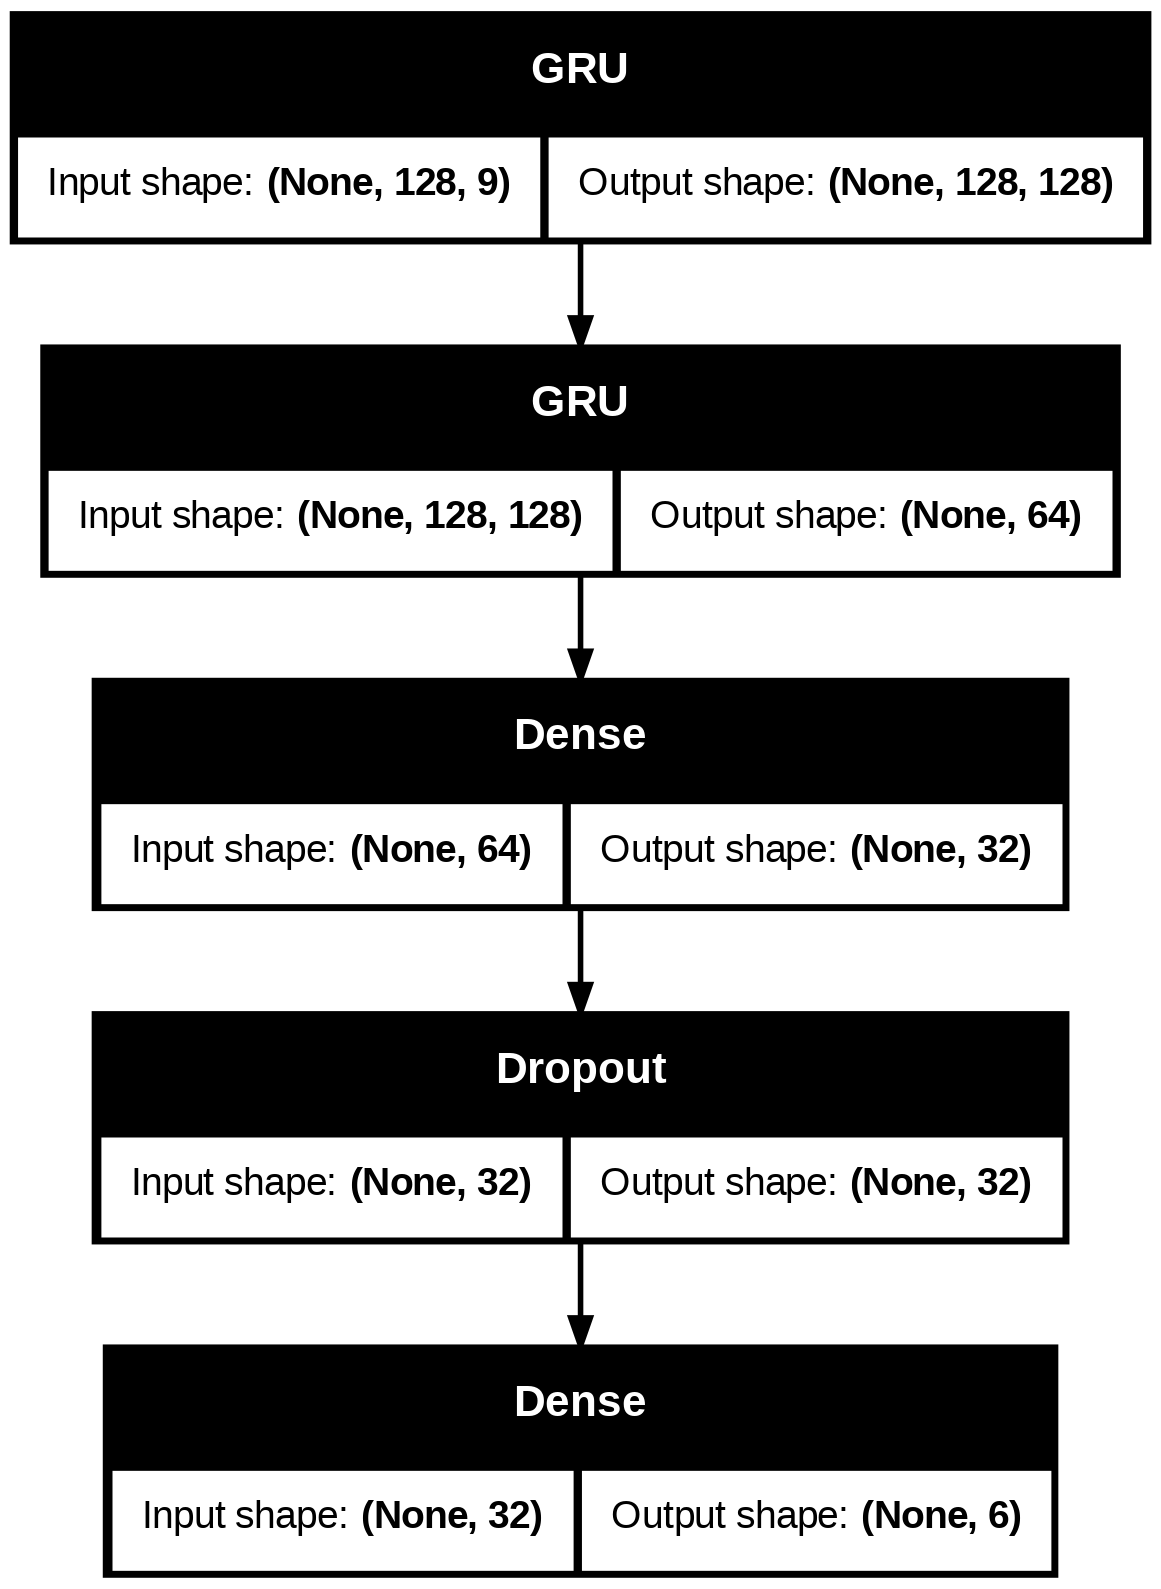

In [7]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [8]:
callbacks = [
            ModelCheckpoint(
                "UCI_HAR_GRU_best.h5",
                save_best_only=True,
                monitor="sparse_categorical_accuracy",
                mode='max',
                verbose=1
            ),
            EarlyStopping(
                monitor="sparse_categorical_accuracy",
                patience=20,
                verbose=1,
                mode='max',
                restore_best_weights=True
            )
        ]

In [9]:
history = model.fit(
            X_train, y_train,
            epochs=100,
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.4529 - sparse_categorical_accuracy: 0.3819
Epoch 1: sparse_categorical_accuracy improved from -inf to 0.44233, saving model to UCI_HAR_GRU_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 1.4523 - sparse_categorical_accuracy: 0.3822
Epoch 2/100
228/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9299 - sparse_categorical_accuracy: 0.6063
Epoch 2: sparse_categorical_accuracy improved from 0.44233 to 0.66757, saving model to UCI_HAR_GRU_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.9281 - sparse_categorical_accuracy: 0.6071
Epoch 3/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5054 - sparse_categorical_accuracy: 0.8058
Epoch 3: sparse_categorical_accuracy improved from 0.66757 to 0.82699, saving model to UCI_HAR_GRU_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.5052 - sparse_categorical_accuracy: 0.8059
Epoch 4/100
227/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3460 - sparse_categorical_accuracy: 0.8657
Epoch 4: sparse_categorical_accuracy improved from 0.82699 to 0.86820, saving model to UCI_HAR_GRU_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.3458 - sparse_categorical_accuracy: 0.8658
Epoch 5/100
228/230 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3347 - sparse_categorical_accuracy: 0.8637
Epoch 5: sparse_categorical_accuracy improved from 0.86820 to 0.87201, saving model to UCI_HAR_GRU_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.3345 - sparse_categorical_accuracy: 0.8638
Epoch 6/100
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2904 - sparse_categorical_accuracy: 0.8817
Epoch 6: sparse_categorical_accuracy improved from 0.87201 to 0.88983, saving model to UCI_HAR_GRU_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.2903 - sparse_categorical_accuracy: 0.8818
Epoch 7/100
226/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2647 - sparse_categorical_accuracy: 0.8899
Epoch 7: sparse_categorical_accuracy did not improve from 0.88983
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.2648 - sparse_categorical_accuracy: 0.8898
Epoch 8/100
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2573 - sparse_categorical_accuracy: 0.8864
Epoch 8: sparse_categorical_accuracy did not improve from 0.88983
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.2573 - sparse_categorical_accuracy: 0.8864
Epoch 9/100
227/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2509 - sparse_categorical_accuracy: 0.8895
Epoch 9: sparse_categorical_accuracy improved from 0.88983 to 0.89391, saving model to UCI_HAR_GRU_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.2508 - sparse_categorical_accuracy: 0.8896
Epoch 10/100
226/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2594 - sparse_categorical_accuracy: 0.8854
Epoch 10: sparse_categorical_accuracy did not improve from 0.89391
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.2594 - sparse_categorical_accuracy: 0.8855
Epoch 11/100
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2423 - sparse_categorical_accuracy: 0.8971
Epoch 11: sparse_categorical_accuracy did not improve from 0.89391
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.2423 - sparse_categorical_accuracy: 0.8970
Epoch 12/100
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2378 - sparse_categorical_accuracy: 0.8929
Epoch 12: sparse_categorical_accuracy improved from 0.89391 to 0.89418, saving model to UCI_HAR_GRU_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.2378 - sparse_categorical_accuracy: 0.8929
Epoch 13/100
228/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2293 - sparse_categorical_accuracy: 0.8867
Epoch 13: sparse_categorical_accuracy did not improve from 0.89418
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.2292 - sparse_categorical_accuracy: 0.8868
Epoch 14/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2294 - sparse_categorical_accuracy: 0.8973
Epoch 14: sparse_categorical_accuracy improved from 0.89418 to 0.89731, saving model to UCI_HAR_GRU_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.2294 - sparse_categorical_accuracy: 0.8973
Epoch 15/100
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2284 - sparse_categorical_accuracy: 0.8928
Epoch 15: sparse_categorical_accuracy did not improve from 0.89731
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.2283 - sparse_categorical_accuracy: 0.8928
Epoch 16/100
227/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2160 - sparse_categorical_accuracy: 0.8986
Epoch 16: sparse_categorical_accuracy improved from 0.89731 to 0.89853, saving model to UCI_HAR_GRU_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.2160 - sparse_categorical_accuracy: 0.8986
Epoch 17/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2326 - sparse_categorical_accuracy: 0.8888
Epoch 17: sparse_categorical_accuracy did not improve from 0.89853
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.2326 - sparse_categorical_accuracy: 0.8889
Epoch 18/100
226/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2185 - sparse_categorical_accuracy: 0.8940
Epoch 18: sparse_categorical_accuracy improved from 0.89853 to 0.90125, saving model to UCI_HAR_GRU_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.2183 - sparse_categorical_accuracy: 0.8942
Epoch 19/100
226/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2037 - sparse_categorical_accuracy: 0.8897
Epoch 19: sparse_categorical_accuracy did not improve from 0.90125
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.2036 - sparse_categorical_accuracy: 0.8899
Epoch 20/100
227/230 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2028 - sparse_categorical_accuracy: 0.9032
Epoch 20: sparse_categorical_accuracy improved from 0.90125 to 0.90479, saving model to UCI_HAR_GRU_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.2029 - sparse_categorical_accuracy: 0.9032
Epoch 21/100
227/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2021 - sparse_categorical_accuracy: 0.9058
Epoch 21: sparse_categorical_accuracy did not improve from 0.90479
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.2022 - sparse_categorical_accuracy: 0.9058
Epoch 22/100
227/230 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2061 - sparse_categorical_accuracy: 0.9009
Epoch 22: sparse_categorical_accuracy did not improve from 0.90479
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.2062 - sparse_categorical_accuracy: 0.9009
Epoch 23/100
228/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2042 - sparse_categorical_accuracy: 0.9043
Epoch 23: sparse_categorical_accuracy did not improve from 0.90479
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2042 - sparse_categorical_accuracy: 0.9043
Epoch 24/100
227/230 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1957 - sparse_categorical_accu

230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1879 - sparse_categorical_accuracy: 0.9073
Epoch 32/100
226/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1872 - sparse_categorical_accuracy: 0.9124
Epoch 32: sparse_categorical_accuracy did not improve from 0.90900
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.1873 - sparse_categorical_accuracy: 0.9123
Epoch 33/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2048 - sparse_categorical_accuracy: 0.9021
Epoch 33: sparse_categorical_accuracy did not improve from 0.90900
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.2048 - sparse_categorical_accuracy: 0.9021
Epoch 34/100
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1946 - sparse_categorical_accuracy: 0.9013
Epoch 34: sparse_categorical_accuracy did not improve from 0.90900
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.1945 - sparse_categorical_accuracy: 0.9013
Epoch 35/100
226/230 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1845 - sparse_categorical_accu

230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1907 - sparse_categorical_accuracy: 0.9087
Epoch 37/100
228/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1913 - sparse_categorical_accuracy: 0.9026
Epoch 37: sparse_categorical_accuracy did not improve from 0.91064
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.1913 - sparse_categorical_accuracy: 0.9026
Epoch 38/100
227/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1846 - sparse_categorical_accuracy: 0.9074
Epoch 38: sparse_categorical_accuracy did not improve from 0.91064
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.1847 - sparse_categorical_accuracy: 0.9073
Epoch 39/100
228/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1755 - sparse_categorical_accuracy: 0.9061
Epoch 39: sparse_categorical_accuracy did not improve from 0.91064
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1756 - sparse_categorical_accuracy: 0.9061
Epoch 40/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1786 - sparse_categorical_accu

230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.1910 - sparse_categorical_accuracy: 0.9105
Epoch 50/100
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1737 - sparse_categorical_accuracy: 0.9094
Epoch 50: sparse_categorical_accuracy did not improve from 0.91390
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1738 - sparse_categorical_accuracy: 0.9094
Epoch 51/100
228/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1738 - sparse_categorical_accuracy: 0.9195
Epoch 51: sparse_categorical_accuracy improved from 0.91390 to 0.91744, saving model to UCI_HAR_GRU_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1737 - sparse_categorical_accuracy: 0.9195
Epoch 52/100
226/230 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1880 - sparse_categorical_accuracy: 0.9079
Epoch 52: sparse_categorical_accuracy did not improve from 0.91744
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.1879 - sparse_categorical_accuracy: 0.9079
Epoch 53/100
228/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1717 - sparse_categorical_accuracy: 0.9180
Epoch 53: sparse_categorical_accuracy did not improve from 0.91744
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1719 - sparse_categorical_accuracy: 0.9179
Epoch 54/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1884 - sparse_categorical_accuracy: 0.9105
Epoch 54: sparse_categorical_accuracy did not improve from 0.91744
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1884 - sparse_categorical_accuracy: 0.9105
Epoch 55/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1672 - sparse_categorical_accu

230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.1765 - sparse_categorical_accuracy: 0.9230
Epoch 60/100
228/230 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1665 - sparse_categorical_accuracy: 0.9239
Epoch 60: sparse_categorical_accuracy did not improve from 0.92002
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1665 - sparse_categorical_accuracy: 0.9238
Epoch 61/100
226/230 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1704 - sparse_categorical_accuracy: 0.9191
Epoch 61: sparse_categorical_accuracy did not improve from 0.92002
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.1704 - sparse_categorical_accuracy: 0.9192
Epoch 62/100
227/230 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1810 - sparse_categorical_accuracy: 0.9098
Epoch 62: sparse_categorical_accuracy did not improve from 0.92002
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.1809 - sparse_categorical_accuracy: 0.9100
Epoch 63/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1688 - sparse_categorical_accu

230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1603 - sparse_categorical_accuracy: 0.9267
Epoch 65/100
228/230 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1691 - sparse_categorical_accuracy: 0.9221
Epoch 65: sparse_categorical_accuracy did not improve from 0.92369
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.1691 - sparse_categorical_accuracy: 0.9221
Epoch 66/100
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1740 - sparse_categorical_accuracy: 0.9197
Epoch 66: sparse_categorical_accuracy did not improve from 0.92369
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.1740 - sparse_categorical_accuracy: 0.9197
Epoch 67/100
228/230 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1679 - sparse_categorical_accuracy: 0.9245
Epoch 67: sparse_categorical_accuracy improved from 0.92369 to 0.92628, saving model to UCI_HAR_GRU_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.1678 - sparse_categorical_accuracy: 0.9246
Epoch 68/100
228/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1650 - sparse_categorical_accuracy: 0.9222
Epoch 68: sparse_categorical_accuracy did not improve from 0.92628
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1650 - sparse_categorical_accuracy: 0.9222
Epoch 69/100
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1651 - sparse_categorical_accuracy: 0.9242
Epoch 69: sparse_categorical_accuracy did not improve from 0.92628
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.1651 - sparse_categorical_accuracy: 0.9242
Epoch 70/100
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1532 - sparse_categorical_accuracy: 0.9299
Epoch 70: sparse_categorical_accuracy improved from 0.92628 to 0.92750, saving model to UCI_HAR_GRU_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1533 - sparse_categorical_accuracy: 0.9299
Epoch 71/100
227/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1970 - sparse_categorical_accuracy: 0.9165
Epoch 71: sparse_categorical_accuracy did not improve from 0.92750
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.1969 - sparse_categorical_accuracy: 0.9166
Epoch 72/100
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1604 - sparse_categorical_accuracy: 0.9315
Epoch 72: sparse_categorical_accuracy improved from 0.92750 to 0.93199, saving model to UCI_HAR_GRU_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.1604 - sparse_categorical_accuracy: 0.9315
Epoch 73/100
226/230 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1661 - sparse_categorical_accuracy: 0.9275
Epoch 73: sparse_categorical_accuracy did not improve from 0.93199
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1660 - sparse_categorical_accuracy: 0.9275
Epoch 74/100
226/230 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1670 - sparse_categorical_accuracy: 0.9249
Epoch 74: sparse_categorical_accuracy did not improve from 0.93199
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.1669 - sparse_categorical_accuracy: 0.9250
Epoch 75/100
228/230 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1441 - sparse_categorical_accuracy: 0.9354
Epoch 75: sparse_categorical_accuracy did not improve from 0.93199
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.1443 - sparse_categorical_accuracy: 0.9353
Epoch 76/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1540 - sparse_categorical_accu

230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1580 - sparse_categorical_accuracy: 0.9314
Epoch 79/100
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1416 - sparse_categorical_accuracy: 0.9397
Epoch 79: sparse_categorical_accuracy improved from 0.93213 to 0.93757, saving model to UCI_HAR_GRU_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1416 - sparse_categorical_accuracy: 0.9397
Epoch 80/100
227/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1522 - sparse_categorical_accuracy: 0.9302
Epoch 80: sparse_categorical_accuracy did not improve from 0.93757
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1522 - sparse_categorical_accuracy: 0.9302
Epoch 81/100
227/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1368 - sparse_categorical_accuracy: 0.9443
Epoch 81: sparse_categorical_accuracy did not improve from 0.93757
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1370 - sparse_categorical_accuracy: 0.9442
Epoch 82/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1665 - sparse_categorical_accuracy: 0.9243
Epoch 82: sparse_categorical_accuracy did not improve from 0.93757
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1664 - sparse_categorical_accuracy: 0.9243
Epoch 83/100
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1428 - sparse_categorical_accu

230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1377 - sparse_categorical_accuracy: 0.9410
Epoch 86/100
227/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1458 - sparse_categorical_accuracy: 0.9367
Epoch 86: sparse_categorical_accuracy did not improve from 0.94165
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1458 - sparse_categorical_accuracy: 0.9367
Epoch 87/100
228/230 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1761 - sparse_categorical_accuracy: 0.9289
Epoch 87: sparse_categorical_accuracy did not improve from 0.94165
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.1760 - sparse_categorical_accuracy: 0.9289
Epoch 88/100
227/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1565 - sparse_categorical_accuracy: 0.9344
Epoch 88: sparse_categorical_accuracy did not improve from 0.94165
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1565 - sparse_categorical_accuracy: 0.9344
Epoch 89/100
226/230 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1371 - sparse_categorical_accu

In [17]:
# 모델 평가
model = tf.keras.models.load_model("UCI_HAR_GRU_best.h5")

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

Training accuracy: 84.41%
Training loss: 0.6179
Test accuracy: 85.04%
Test loss: 0.6053


model.predict
- 각 시퀀스 샘플마다, 모든 클래스에 대한 예측 확률 벡터
- y_pred_proba.shape -> (샘플 수, 클래스 수)

np.argmax
- 최대 값의 인덱스를 선택 = 라벨

In [18]:
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9294    0.9634       496
           1     0.9936    0.9830    0.9883       471
           2     0.9067    0.9952    0.9489       420
           3     0.5621    0.8758    0.6847       491
           4     0.9111    0.7707    0.8350       532
           5     0.9419    0.6034    0.7355       537

    accuracy                         0.8504      2947
   macro avg     0.8859    0.8596    0.8593      2947
weighted avg     0.8861    0.8504    0.8542      2947



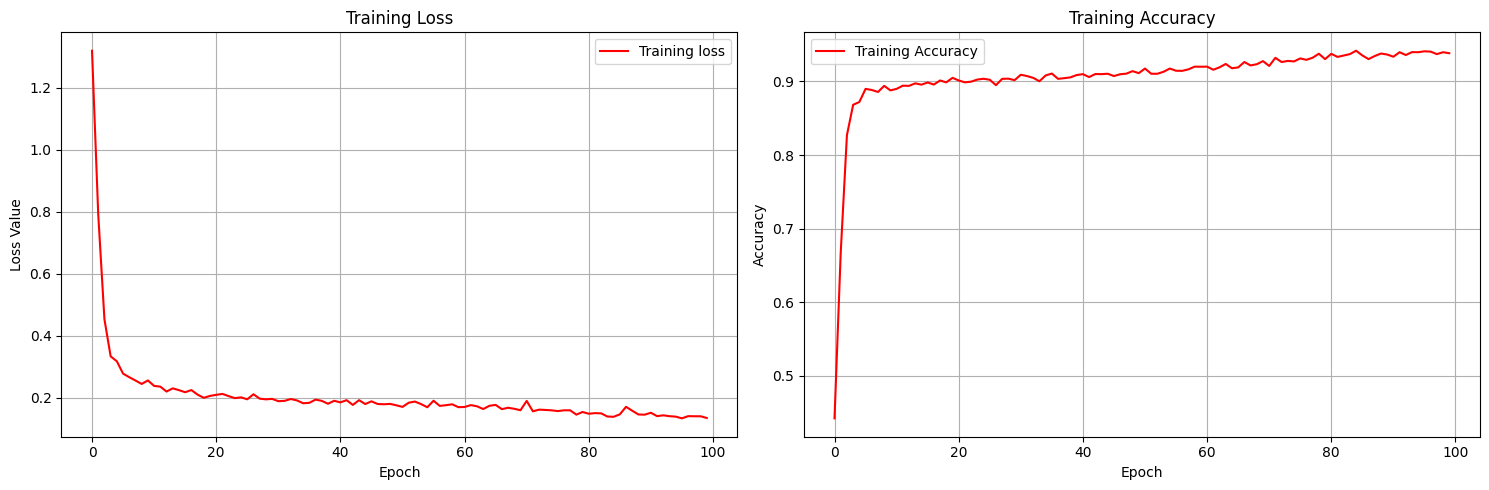

In [20]:
train_loss = history.history['loss']
train_accuracy = history.history['sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

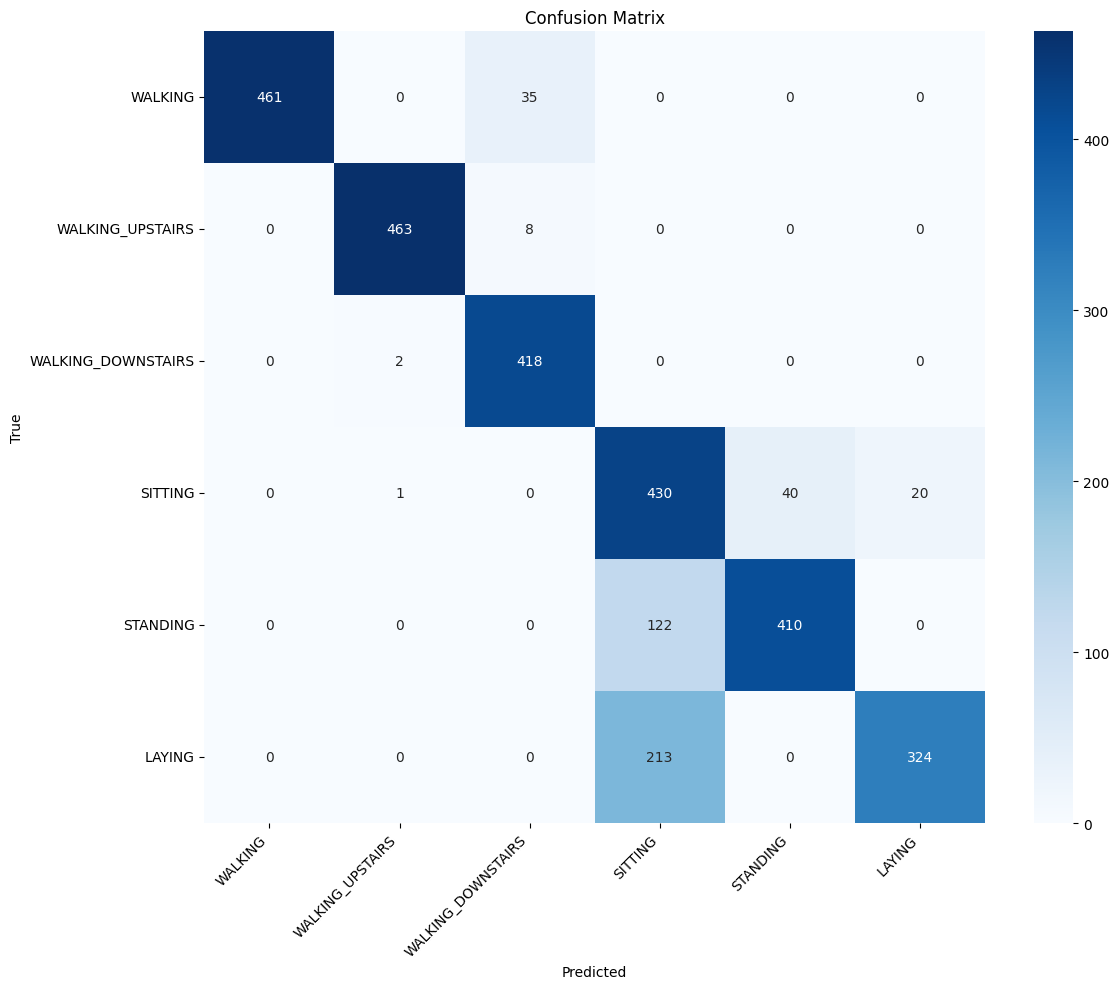

In [14]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

n_classes = len(np.unique(y_test))
if n_classes <= len(LABELS):
    plt.gca().set_xticklabels(LABELS[:n_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(LABELS[:n_classes], rotation=0)

plt.tight_layout()
plt.show()